![text](header_workflow.png)

### MLP-based model training 

#### Libraries

In [1]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2026-01-21 14:41:45.399353: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-21 14:41:45.763392: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-21 14:41:46.612256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Enable GPU 

In [2]:
# GPU
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

GPUs:  1


2026-01-21 14:41:47.881751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-21 14:41:48.072245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-21 14:41:48.072406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

#### Load dataset

In [3]:
# Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0          


#### Fashion MNIST: classes

| Label | Class |  
|-----------|-----------|
|0  | T-shirt/top	   |
|1	|Trouser    |
|2	|Pullover|
|3	|Dress|
|4	|Coat|
|5	|Sandal|
|6	|Shirt|
|7	|Sneaker|
|8	|Bag	|
|9	|Ankle boot|

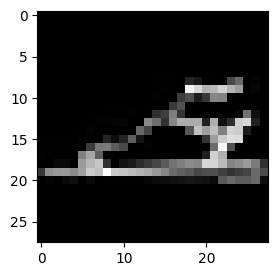

In [5]:
# Image index

N = 300

plt.figure(figsize=(3,3))
plt.imshow(x_train[N], cmap='gray')

In [6]:
# Labels
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### Model definition



In [ ]:
# MLP architecture

w = 28
h = 28
n_classes = 10

model= Sequential([

    Flatten(input_shape=(w, h)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')

])


2026-01-21 14:43:24.784344: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x3bd30de0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-01-21 14:43:24.784437: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2026-01-21 14:43:24.785168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-21 14:43:24.785745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
20

### Build model

In [8]:
lr = 0.001
# op = Adam(lr)
op = SGD(lr)

model.compile(loss='sparse_categorical_crossentropy', optimizer=op, metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 219,818
Trainable params: 219,818
Non-trai

### Model training

In [10]:
history = model.fit(x_train_norm, y_train, epochs= 32, batch_size = 50, validation_split=0.2)

Epoch 1/32


2026-01-21 14:46:46.693628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2026-01-21 14:46:46.871274: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2026-01-21 14:46:46.963930: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


960/960 [==============================] - 2s 1ms/step - loss: 1.9872 - accuracy: 0.3623 - val_loss: 1.6057 - val_accuracy: 0.5399
Epoch 2/32
960/960 [==============================] - 1s 1ms/step - loss: 1.4045 - accuracy: 0.5699 - val_loss: 1.1161 - val_accuracy: 0.6510
Epoch 3/32
960/960 [==============================] - 1s 1ms/step - loss: 1.0694 - accuracy: 0.6406 - val_loss: 0.9021 - val_accuracy: 0.6872
Epoch 4/32
960/960 [==============================] - 1s 1ms/step - loss: 0.9173 - accuracy: 0.6799 - val_loss: 0.8012 - val_accuracy: 0.7235
Epoch 5/32
960/960 [==============================] - 1s 1ms/step - loss: 0.8365 - accuracy: 0.7069 - val_loss: 0.7434 - val_accuracy: 0.7400
Epoch 6/32
960/960 [==============================] - 1s 1ms/step - loss: 0.7878 - accuracy: 0.7255 - val_loss: 0.7051 - val_accuracy: 0.7549
Epoch 7/32
960/960 [==============================] - 1s 1ms/step - loss: 0.7455 - accuracy: 0.7406 - val_loss: 0.6716 - val_accuracy: 0.7669
Epoch 8/32
960/96

In [11]:
# Model evaluation
test_loss, test_acc = model.evaluate(x_test_norm, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

313/313 [==============================] - 0s 850us/step - loss: 0.4730 - accuracy: 0.8348

Test accuracy: 0.8348


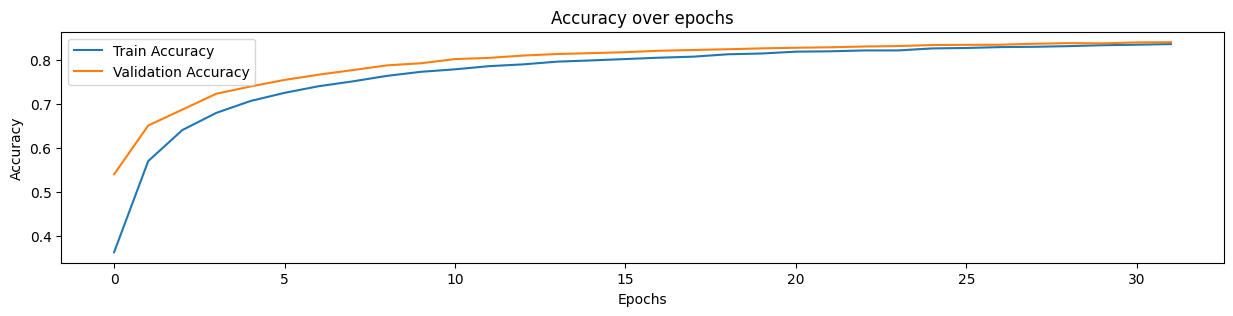

In [12]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

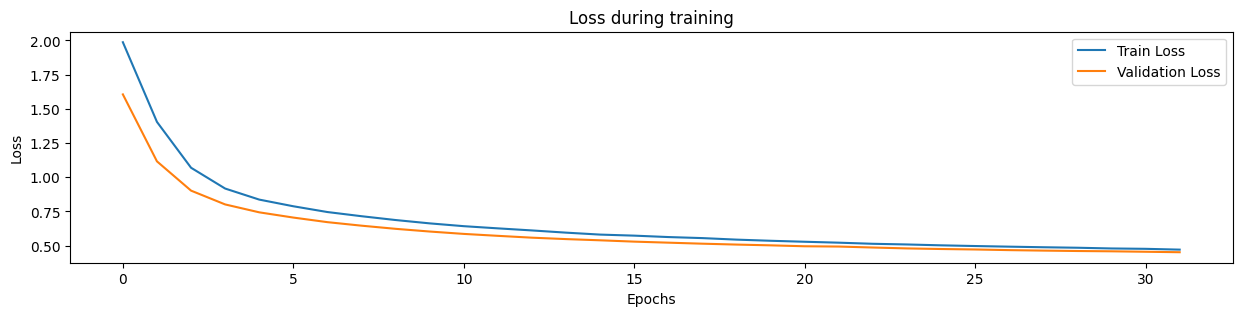

In [13]:
# Plot accuracy over loss
plt.figure(figsize=(15,3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.legend()
plt.show()

### Inference test

1/1 [==============================] - 0s 14ms/step
Predicted Class: 0 | True label: 0


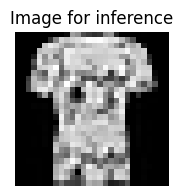

In [16]:
index = 400

plt.figure(figsize=(2,2))
plt.imshow(x_test[index], cmap='gray')
plt.axis("off")
plt.title("Image for inference")

x_in = x_test_norm[index].reshape(1, 28,28)

y_pred = model.predict(x_in)
pred_class = np.argmax(y_pred, axis=1)[0]

print(f"Predicted Class: {pred_class} | True label: {y_test[index]}")


### Confusion Matrix

313/313 [==============================] - 0s 548us/step


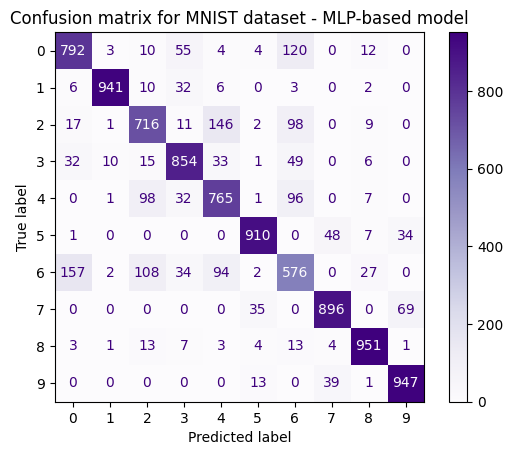

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score


y_pred_probs = model.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'Purples')
plt.title('Confusion matrix for MNIST dataset - MLP-based model')
plt.show()

In [18]:
model.save("fashionMNIST.h5")